In [1]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import torch
from diffusers import PNDMScheduler, StableDiffusionPipeline
from PIL import Image
from torchvision import transforms

/Users/jeremiahfisher/miniforge3/envs/slowai/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
η = 1
T_SKIP = 36
N_DIFFUSION_STEPS = 100
DEVICE = "mps"
MODEL_ID = "CompVis/stable-diffusion-v1-4"
CFG_SCALE_SRC = 3.5
CFG_SCALE_TGT = 15
INITIAL_IMAGE = "horse_mud.jpg"
PROMPT_SRC = "a photo of a horse in the mud"
PROMPT_TGT = "a photo of a horse in the snow"

In [3]:
rng = torch.manual_seed(42)
pipe = StableDiffusionPipeline.from_pretrained(MODEL_ID).to(DEVICE)
pipe.scheduler.set_timesteps(N_DIFFUSION_STEPS)
img = Image.open(INITIAL_IMAGE)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [4]:
def compress(img):
    """Project pixels into latent space"""
    VAE_TO_UNET_SCALING_FACTOR = 0.18215
    to_tensor = transforms.ToTensor()
    img = to_tensor(img).unsqueeze(0).to(DEVICE)
    img = img * 2 - 1  # Note scaling
    with torch.no_grad():
        latents = pipe.vae.encode(img)
    return VAE_TO_UNET_SCALING_FACTOR * latents.latent_dist.sample()


x0 = compress(img)

In [5]:
def tokenize_and_encode(prompt, max_length):
    prompt_tokens = pipe.tokenizer(
        prompt,
        padding="max_length",
        max_length=max_length,
        truncation=True,
        return_tensors="pt",
    )
    with torch.no_grad():
        return pipe.text_encoder(prompt_tokens.input_ids.to(DEVICE)).last_hidden_state


def embed_prompt(prompt):
    cond_embedding = tokenize_and_encode(prompt, pipe.tokenizer.model_max_length)
    _, max_length, _ = cond_embedding.shape
    uncond_embedding = tokenize_and_encode("", max_length)
    return torch.cat([cond_embedding, uncond_embedding])


prompt_embedding_src = embed_prompt(PROMPT_SRC)
prompt_embedding_src.shape

torch.Size([2, 77, 768])

`alphas_cumprod` is defined somewhat clumsily for all possible total time steps, and is reordered when indexed by the specific `pipe.scheduler.timesteps` for our run. Therefore, we define `ᾱs` such that `ᾱs[t]` corresponds to the $\bar{\alpha}_t$ for a solver with `N_DIFFUSION_STEPS`.

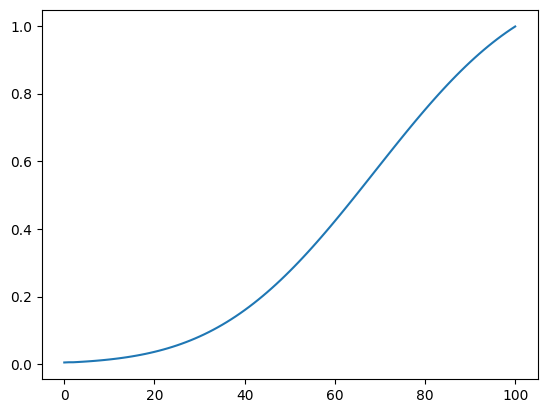

In [6]:
ᾱs = pipe.scheduler.alphas_cumprod[pipe.scheduler.timesteps]
plt.plot(ᾱs);

With that convenience variables, we implement equation 2, which is the crux of the algorithm.

This is the first loop, calculating $x_i \forall i \in \{1 \dots T\}$

In [7]:
xts = []
for ᾱ_t in ᾱs:
    Ɛ̃ = torch.rand_like(x0, device=DEVICE)
    xt = torch.sqrt(ᾱ_t) * x0 + torch.sqrt(1 - ᾱ_t) * Ɛ̃
    xts.append(xt)
len(xts)

101

In [ ]:
zs = []
for t, xt, ᾱ_t in zip(
    reversed(pipe.scheduler.timesteps),
    reversed(xts),
    reversed(ᾱs),
):
    # prompt_embedding_src = torch.cat([cond_embedding, uncond_embedding])
    c, u = pipe.unet(torch.cat([xt, xt]), t, prompt_embedding_src).sample.chunk(2)
    ε_pred = u + CFG_SCALE_SRC * (c - u)
    x0_pred = (xt - torch.sqrt(1 - ᾱ_t) * ε_pred) / torch.sqrt(ᾱ_t)